In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from pathlib import Path
import time, copy

In [2]:
# Load data

X_train = pd.read_csv(Path('cleaned_data','X_train.csv'), index_col=0)
X_val = pd.read_csv(Path('cleaned_data','X_val.csv'), index_col=0)
X_test = pd.read_csv(Path('cleaned_data','X_test.csv'), index_col=0)

y_train = pd.read_csv(Path('cleaned_data','y_train.csv'), index_col=0)
y_val = pd.read_csv(Path('cleaned_data','y_val.csv'), index_col=0)
y_test = pd.read_csv(Path('cleaned_data','y_test.csv'), index_col=0)

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

from tabpfn import TabPFNClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_curve, auc

In [6]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=42, max_iter=300)

grid = {
        "activation": ['relu', 'identity', 'logistic', 'tanh'],
        "solver": ['lbfgs', 'sgd', 'adam'],
        "learning_rate_init": stats.uniform(0.00001, 0.1),
        "learning_rate": ['constant', 'invscaling', 'adaptive'],
        "momentum": stats.uniform(loc=0.7, scale=0.3),
        }

rs_mlp = RandomizedSearchCV(mlp, n_iter=1, cv=2, verbose=1, param_distributions=grid, n_jobs = 1)

rs_mlp.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", rs_mlp.best_params_)
print("Best score: ", rs_mlp.best_score_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\Vinicius\OneDrive\Documentos\GitHub\mimic-iv-machine-learning-project\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Vinicius\OneDrive\Documentos\GitHub\mimic-iv-machine-learning-project\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Vinicius\OneDrive\Documentos\GitHub\mimic-iv-machine-learning-project\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rave

Best set of hyperparameters:  {'activation': 'relu', 'learning_rate': 'constant', 'learning_rate_init': 0.05844349136659784, 'momentum': 0.9546698005959608, 'solver': 'sgd'}
Best score:  0.7473716310408922


In [7]:
from sklearn.metrics import classification_report

# Fazendo previsões no dataset de validação
prob_pos_mlp = rs_mlp.predict_proba(X_val)[:, 1]
y_pred_mlp = rs_mlp.predict(X_val)

print('MLP - Validation dataset')
print("Accuracy: {:.4f}".format(accuracy_score(y_val, y_pred_mlp)))
print("Precision: {:.4f}".format(precision_score(y_val, y_pred_mlp)))
print("Recall: {:.4f}".format(recall_score(y_val, y_pred_mlp)))
print("AUC: {:.4f}".format(roc_auc_score(y_val, prob_pos_mlp)))
print(classification_report(y_val, y_pred_mlp))

MLP - Validation dataset
Accuracy: 0.7485
Precision: 0.7164
Recall: 0.7813
AUC: 0.8273
              precision    recall  f1-score   support

           0       0.78      0.72      0.75     20036
           1       0.72      0.78      0.75     18222

    accuracy                           0.75     38258
   macro avg       0.75      0.75      0.75     38258
weighted avg       0.75      0.75      0.75     38258



In [8]:
# Fazendo previsões no dataset de testidação
prob_pos_mlp = rs_mlp.predict_proba(X_test)[:, 1]
y_pred_mlp = rs_mlp.predict(X_test)

print('MLP - Test dataset')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_mlp)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_mlp)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_mlp)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_mlp)))
print(classification_report(y_test, y_pred_mlp))

MLP - Test dataset
Accuracy: 0.7451
Precision: 0.7148
Recall: 0.7778
AUC: 0.8248
              precision    recall  f1-score   support

           0       0.78      0.72      0.75     22164
           1       0.71      0.78      0.74     20345

    accuracy                           0.75     42509
   macro avg       0.75      0.75      0.75     42509
weighted avg       0.75      0.75      0.75     42509



In [3]:
# Define device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# Define custom dataset

class MimicIvDataset(Dataset):
    """MIMIC IV dataset."""

    def __init__(self, csv_file_X, csv_file_y):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
        """
        self.mimic_df_X = pd.read_csv(Path(csv_file_X), index_col=0)
        self.mimic_df_y = pd.read_csv(Path(csv_file_y), index_col=0)

    def __len__(self):
        return len(self.mimic_df_X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        inputs = torch.tensor(self.mimic_df_X.iloc[idx], dtype=torch.float64)
        labels = torch.tensor(self.mimic_df_y.iloc[idx], dtype=torch.float64)

        return inputs, labels

In [5]:
# Load datasets

train_dataset = MimicIvDataset(csv_file_X="cleaned_data/X_train.csv", csv_file_y="cleaned_data/y_train.csv")
val_dataset = MimicIvDataset(csv_file_X="cleaned_data/X_val.csv", csv_file_y="cleaned_data/y_val.csv")
test_dataset = MimicIvDataset(csv_file_X="cleaned_data/X_test.csv", csv_file_y="cleaned_data/y_test.csv")

In [6]:
# Create dataloaders

batch_size = 100

dataloaders = {'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=True),
               'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=True)}

dataset_sizes = {'train': len(train_dataset),
                 'val': len(val_dataset),
                 'test': len(test_dataset)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 344320, 'val': 38258, 'test': 42509}


In [7]:
import torch
import torch.nn as nn

# Define model parameters
input_size = 67
hidden_size1 = 128
hidden_size2 = 128
hidden_size3 = 128
num_classes = 1
dropout_rate = 0.5  # Adjust the dropout rate for regularization

# External training parameters
learning_rate = 0.0001
num_epochs = 10

# Revised model with flexible activation and data types
class MimicAdmissionClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes, dropout_rate, activation_fn=nn.ReLU, dtype=torch.float32):
        """
        A customizable multi-layer perceptron (MLP) model with dropout for classification tasks.

        Args:
            input_size (int): Size of the input features.
            hidden_size1 (int): Number of units in the first hidden layer.
            hidden_size2 (int): Number of units in the second hidden layer.
            hidden_size3 (int): Number of units in the third hidden layer.
            num_classes (int): Number of output classes (1 for binary classification).
            dropout_rate (float): Dropout rate to use between layers (0 for no dropout).
            activation_fn (torch.nn.Module): Activation function (default is ReLU).
            dtype (torch.dtype): Data type for the model (default is torch.float32).
        """
        super(MimicAdmissionClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer to prevent overfitting
        
        # Define the sequence of layers with dynamic activation function
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1, dtype=dtype),
            activation_fn(),
            self.dropout,
            nn.Linear(hidden_size1, hidden_size2, dtype=dtype),
            activation_fn(),
            self.dropout,
            # nn.Linear(hidden_size2, hidden_size3, dtype=dtype),
            # activation_fn(),
            # self.dropout,
            nn.Linear(hidden_size3, num_classes, dtype=dtype),
            nn.Sigmoid()  # For binary classification
        )

    def forward(self, x):
        """
        Forward pass of the network.

        Args:
            x (Tensor): Input data tensor of shape (batch_size, input_size).
        
        Returns:
            Tensor: Output prediction tensor of shape (batch_size, num_classes).
        """
        return self.layers(x)

# Example instantiation of the model
mimic_admission_classifier = MimicAdmissionClassifier(
    input_size=input_size,
    hidden_size1=hidden_size1,
    hidden_size2=hidden_size2,
    hidden_size3=hidden_size3,
    num_classes=num_classes,
    dropout_rate=dropout_rate,
    activation_fn=nn.ReLU,  # Can be changed to other activations like nn.LeakyReLU
    dtype=torch.float64  # Data type can be changed if needed
).to(device)

# Print model summary (optional)
print(mimic_admission_classifier)


MimicAdmissionClassifier(
  (dropout): Dropout(p=0.5, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=67, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [8]:
# From https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy, BinaryAUROC

def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=5, threshold=0.5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0
    best_f1 = 0
    best_auc = 0.5

    # initialize metric
    f1 = BinaryF1Score(threshold=threshold).to(device)
    acc = BinaryAccuracy(threshold=threshold).to(device)
    auc = BinaryAUROC().to(device)

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']
    
    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []
        training_curves[phase+'_f1'] = []
        training_curves[phase+'_auc'] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            since_phase = time.time()
                        
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # No need to flatten the inputs!
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                f1_score = f1(outputs.detach(), labels.detach())
                acc_score = acc(outputs.detach(), labels.detach())
                auc_score = auc(outputs.detach(), labels.detach())
                            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = acc.compute()
            epoch_f1 = f1.compute()
            epoch_auc = auc.compute()
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)       
            training_curves[phase+'_f1'].append(epoch_f1)
            training_curves[phase+'_auc'].append(epoch_auc)
            phase_time_elapsed = time.time() - since_phase

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f} AUC: {epoch_auc:.4f} Time elapsed: {phase_time_elapsed // 60:.0f}m {phase_time_elapsed % 60:.0f}s')

            # deep copy the model if it's the best F1
            if phase == 'val' and epoch_auc > best_auc:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
              best_f1 = epoch_f1
              best_auc = epoch_auc

            # reset metrics
            f1.reset()
            acc.reset()

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch} with F1-score: {best_f1} with AUC {best_auc}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, training_curves

In [9]:
# Training
# loss and optimizer
criterion = nn.BCELoss() # BCELoss for binary classification
optimizer = torch.optim.Adam(mimic_admission_classifier.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
mimic_admission_classifier, training_curves = train_classification_model(mimic_admission_classifier, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=20)


Epoch 1/20
----------


C:\Users\Vinicius\AppData\Local\Temp\ipykernel_26820\1375628816.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.mimic_df_X.iloc[idx], dtype=torch.float64)
C:\Users\Vinicius\AppData\Local\Temp\ipykernel_26820\1375628816.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.tensor(self.mimic_df_y.iloc[idx], dtype=torch.float64)


train Loss: 0.5437 Acc: 0.7278 F1: 0.7187 AUC: 0.7993 Time elapsed: 2m 55s
val   Loss: 0.5159 Acc: 0.7450 F1: 0.7401 AUC: 0.8016 Time elapsed: 0m 35s
test  Loss: 0.5190 Acc: 0.7407 F1: 0.7373 AUC: 0.8034 Time elapsed: 0m 42s

Epoch 2/20
----------


KeyboardInterrupt: 

In [53]:
import sklearn.metrics as metrics

# Utility functions for plotting your results!
def plot_training_curves(training_curves, 
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc', 'f1', 'auc']):
    epochs = list(range(1, len(training_curves['train_loss'])+1))
    fig, axs = plt.subplots(len(metrics), 1, figsize=(5, 10), tight_layout=True)
    for idx, metric in enumerate(metrics):
        ax = axs[idx]     
        ax.set_title(f'Training curves - {metric}')
        ax.set_ylabel(metric)
        ax.xaxis.set_ticks(np.arange(1, len(epochs)+1, 1))
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc' or metric == 'f1' or metric == 'auc':
                    ax.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    ax.plot(epochs, training_curves[key])
        ax.set_xlabel('epoch')
        ax.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = torch.where(outputs < 0.5, 0, 1).view(-1)
        scores = outputs.view(-1)
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0).view(-1)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])
    
    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')

In [55]:
training_curves

{'train_loss': [0.5109811729204516],
 'train_acc': [tensor(0.7492, device='cuda:0')],
 'train_f1': [tensor(0.7404, device='cuda:0')],
 'train_auc': [tensor(0.8264, device='cuda:0')],
 'val_loss': [0.5058639691958685],
 'val_acc': [tensor(0.7509, device='cuda:0')],
 'val_f1': [tensor(0.7425, device='cuda:0')],
 'val_auc': [tensor(0.8267, device='cuda:0')],
 'test_loss': [0.5092330404016869],
 'test_acc': [tensor(0.7479, device='cuda:0')],
 'test_f1': [tensor(0.7404, device='cuda:0')],
 'test_auc': [tensor(0.8267, device='cuda:0')]}

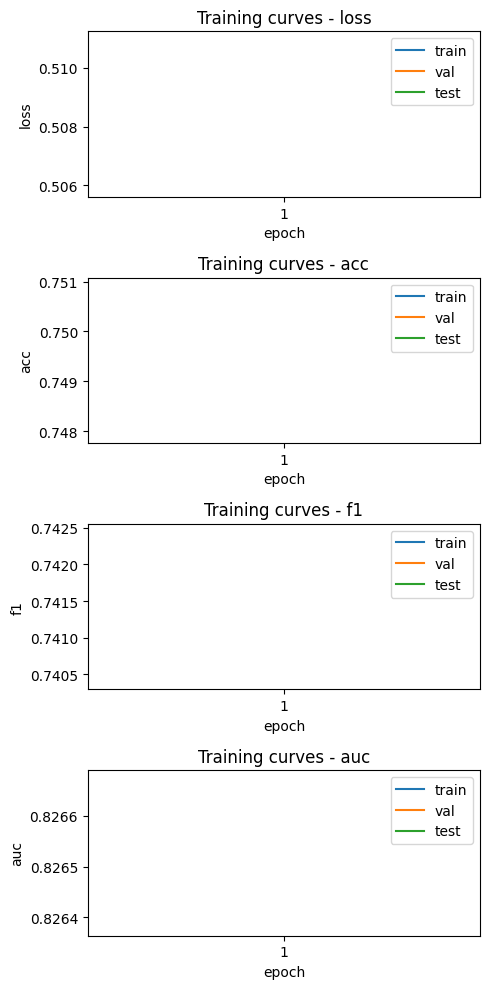

In [58]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])


In [ ]:
mimic_admission_classifier()

In [ ]:
from sklearn.metrics import classification_report

# Fazendo previsões no dataset de validação
prob_pos_mlp = rs_mlp.predict_proba(X_val)[:, 1]
y_pred_mlp = rs_mlp.predict(X_val)

print('MLP - Validation dataset')
print("Accuracy: {:.4f}".format(accuracy_score(y_val, y_pred_mlp)))
print("Precision: {:.4f}".format(precision_score(y_val, y_pred_mlp)))
print("Recall: {:.4f}".format(recall_score(y_val, y_pred_mlp)))
print("AUC: {:.4f}".format(roc_auc_score(y_val, prob_pos_mlp)))
print(classification_report(y_val, y_pred_mlp))